In [1]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]


# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

In [4]:
df = pd.read_pickle('../data/LP_Simulations_Formatted.pkl')
df

,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject
0,0.000000,0.054566,0.058537,0.062743,0.155728,0.023906,0.021142,0.070465,-9.259692,-4.447818,-6.536988,0.026819,6.26_0.9_1.06
1,0.009799,0.054646,0.058400,0.062911,0.154414,0.023787,0.021018,0.077124,-9.502468,-4.600985,-6.520491,0.026349,6.26_0.9_1.06
2,0.019599,0.054800,0.057753,0.062681,0.153220,0.023763,0.021220,0.095268,-9.513043,-4.624847,-6.518658,0.026434,6.26_0.9_1.06
3,0.029398,0.056122,0.056917,0.063201,0.157919,0.023762,0.022113,0.114959,-9.409544,-4.564386,-6.497891,0.026648,6.26_0.9_1.06
4,0.039197,0.057602,0.056416,0.063981,0.163014,0.023785,0.023148,0.126942,-9.251525,-4.474644,-6.437751,0.026858,6.26_0.9_1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345171,1.950067,0.077327,0.028705,0.070763,0.186818,0.081797,0.022118,0.090759,-4.916051,-5.716611,-12.003086,0.024750,6.53_1.04_1.02
1345172,1.959866,0.077751,0.027808,0.071065,0.191791,0.082448,0.022103,0.095652,-5.248973,-5.937422,-12.067884,0.024120,6.53_1.04_1.02
1345173,1.969666,0.078584,0.027024,0.071566,0.193814,0.083229,0.022089,0.093776,-5.556444,-6.157407,-12.143441,0.023570,6.53_1.04_1.02
1345174,1.979465,0.078977,0.026315,0.071994,0.195077,0.083762,0.022077,0.086941,-5.809779,-6.380327,-12.206728,0.023072,6.53_1.04_1.02


In [5]:
# first lets split the dataframe into a train and test set using the Subject column. Keep subjects separate during training and testing
#df = dd.from_pandas(df, npartitions=4)
subject_dfs = split_df_into_subjects(df)
train_split = 0.9
n_train_subjects = int(len(subject_dfs) * train_split)
n_test_subjects = len(subject_dfs) - n_train_subjects


In [6]:
n_test_subjects, n_train_subjects

(52, 466)

In [7]:
# randomly pick the subjects to use for training and testing
train_subjects_index = np.random.choice(len(subject_dfs), n_train_subjects, replace=False)
train_df = pd.concat([subject_dfs[i] for i in train_subjects_index])
test_df = pd.concat([subject_dfs[i] for i in range(len(subject_dfs)) if i not in train_subjects_index])
window_size = 100
stride = 50

In [8]:
train_data = Dataset_LSTM(train_df, sort_column=['Subject'], window_size=window_size, stride=stride)

In [9]:
test_data = Dataset_LSTM(test_df, sort_column=['Subject'], window_size=window_size, stride=stride)

In [10]:
train_data.X.shape, test_data.X.shape

((17682, 100, 8), (2100, 100, 8))

In [11]:
train_data.X = torch.from_numpy(train_data.X).float()
train_data.Y = torch.from_numpy(train_data.Y).float()
test_data.X = torch.from_numpy(test_data.X).float()
test_data.Y = torch.from_numpy(test_data.Y).float()

In [12]:
train_data[0]

(tensor([[0.0346, 0.0314, 0.1292, 0.0272, 0.0296, 0.0460, 0.0220, 0.0695],
         [0.0354, 0.0313, 0.1323, 0.0270, 0.0282, 0.0466, 0.0220, 0.0610],
         [0.0361, 0.0312, 0.1362, 0.0269, 0.0271, 0.0470, 0.0220, 0.0542],
         [0.0368, 0.0311, 0.1416, 0.0267, 0.0264, 0.0477, 0.0220, 0.0493],
         [0.0371, 0.0309, 0.1438, 0.0265, 0.0260, 0.0481, 0.0220, 0.0462],
         [0.0378, 0.0307, 0.1487, 0.0263, 0.0257, 0.0484, 0.0220, 0.0446],
         [0.0387, 0.0306, 0.1519, 0.0261, 0.0252, 0.0488, 0.0220, 0.0440],
         [0.0392, 0.0305, 0.1547, 0.0259, 0.0247, 0.0491, 0.0220, 0.0448],
         [0.0396, 0.0304, 0.1564, 0.0257, 0.0242, 0.0493, 0.0220, 0.0503],
         [0.0398, 0.0303, 0.1561, 0.0255, 0.0238, 0.0492, 0.0220, 0.0582],
         [0.0400, 0.0302, 0.1572, 0.0253, 0.0234, 0.0491, 0.0220, 0.0684],
         [0.0403, 0.0300, 0.1596, 0.0252, 0.0231, 0.0493, 0.0220, 0.0765],
         [0.0409, 0.0298, 0.1631, 0.0251, 0.0227, 0.0499, 0.0220, 0.0827],
         [0.0417, 0.0296,

Text(0, 0.5, 'Force')

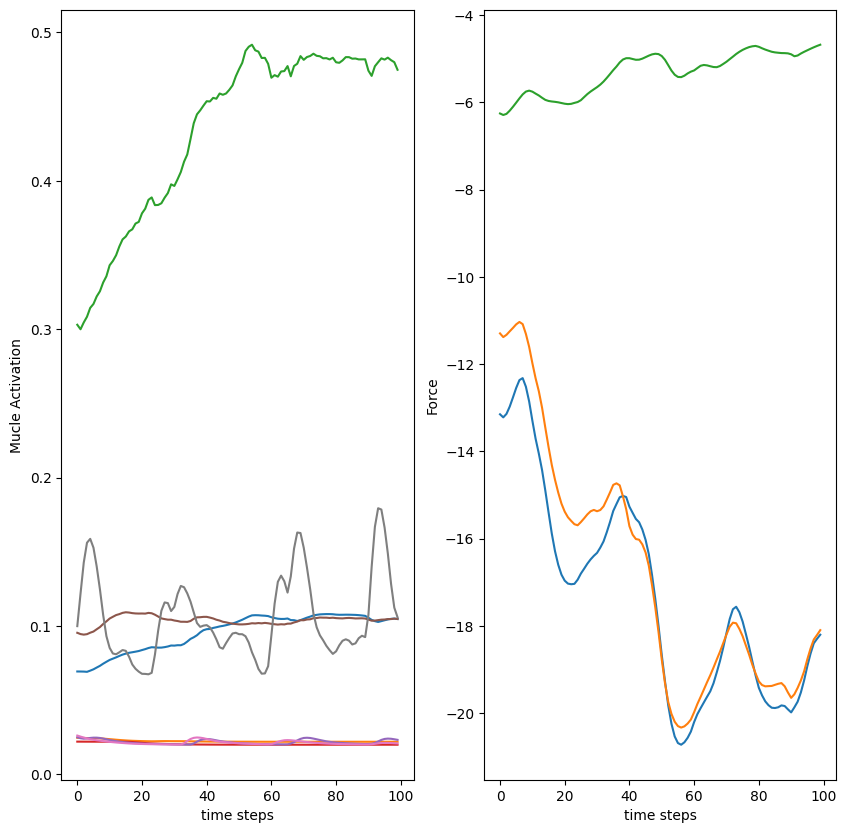

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(train_data[1][0])
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(train_data[1][1])
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')

In [14]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [15]:
# PASS A SAMPLE THROUGH TO FIX THE MODEL DIMENSIONS
model(train_data.X[0:10].to('cuda'))
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3000, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [16]:
losses = kmk.run_Pytorch(model, train_data.X.reshape(-1, 100, 8), train_data.Y, n_epochs=101, batch_size=256*16, learning_rate=1e-3, device='cuda')

EPOCH :  0 , dt:  1.2084884643554688 seconds, losses : 217.71807861328125
EPOCH :  10 , dt:  10.776161670684814 seconds, losses : 98.37869262695312
EPOCH :  20 , dt:  10.816747188568115 seconds, losses : 35.36933135986328
EPOCH :  30 , dt:  9.872968673706055 seconds, losses : 31.048255920410156
EPOCH :  40 , dt:  9.802289724349976 seconds, losses : 29.508798599243164
EPOCH :  50 , dt:  9.831751346588135 seconds, losses : 20.482542037963867
EPOCH :  60 , dt:  9.837865352630615 seconds, losses : 12.310195922851562
EPOCH :  70 , dt:  9.810696125030518 seconds, losses : 10.25778579711914
EPOCH :  80 , dt:  9.762001276016235 seconds, losses : 9.366222381591797
EPOCH :  90 , dt:  9.792888879776001 seconds, losses : 8.880754470825195
EPOCH :  100 , dt:  10.841269493103027 seconds, losses : 8.59305477142334


In [17]:
import gc
def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

In [18]:
torch.cuda.empty_cache()
gc.collect()
batch_predict(model, train_data.X.to('cuda'))

tensor([[ -9.7350,  -7.1218,  -7.5527,  ..., -15.6469, -13.8479,  -6.4035],
        [-15.3445, -11.9184,  -6.0227,  ..., -22.8328, -19.5141,  -4.9030],
        [-17.9838, -14.2072,  -4.0796,  ..., -25.6655, -21.2068,  -3.1763],
        ...,
        [ -9.9874,  -7.3887,  -6.8546,  ..., -15.7781, -13.8233,  -5.7707],
        [-15.3875, -11.9899,  -5.8296,  ..., -22.8336, -19.4942,  -4.7339],
        [-17.9532, -14.1640,  -4.4916,  ..., -25.7429, -21.3523,  -3.5529]])

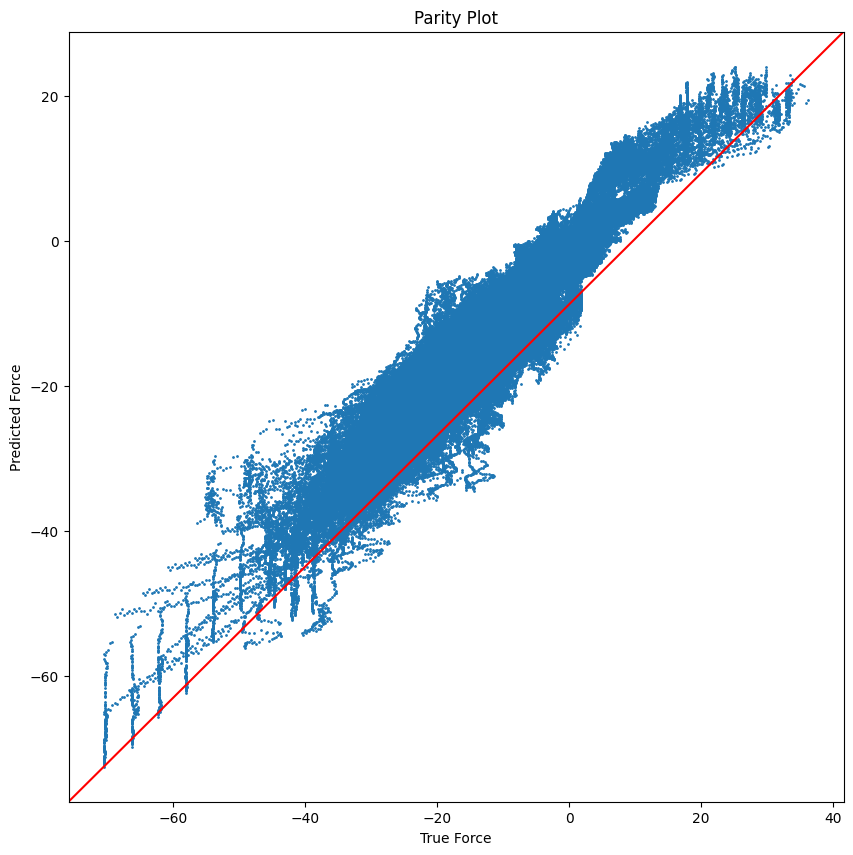

In [19]:
pred = batch_predict(model, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(test_data.Y.flatten(), pred.flatten())
mae = mean_absolute_error(test_data.Y.flatten(), pred.flatten())
mse = mean_squared_error(test_data.Y.flatten(), pred.flatten())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9024586866208159 mae:  2.0111213 mse:  8.079


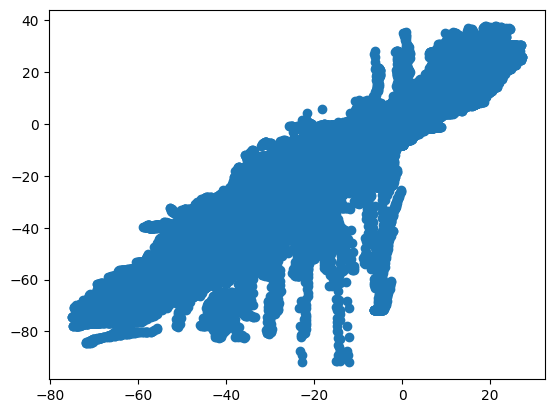

In [21]:
model = model.to('cuda')
pred_train = batch_predict(model, train_data.X.to('cuda'), batch_size=256*16).reshape(-1,1)
y_train = train_data.Y.float().detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred_train, y_train)



In [22]:
r2 = r2_score(y_train, pred_train.flatten())
mae = mean_absolute_error(y_train, pred_train.flatten())
mse = mean_squared_error(y_train, pred_train.flatten())
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)

r2:  0.9187368927401244 mae:  1.9390215 mse:  8.126825


(100, 3)
[-24.592207 -20.866436  -6.241374]


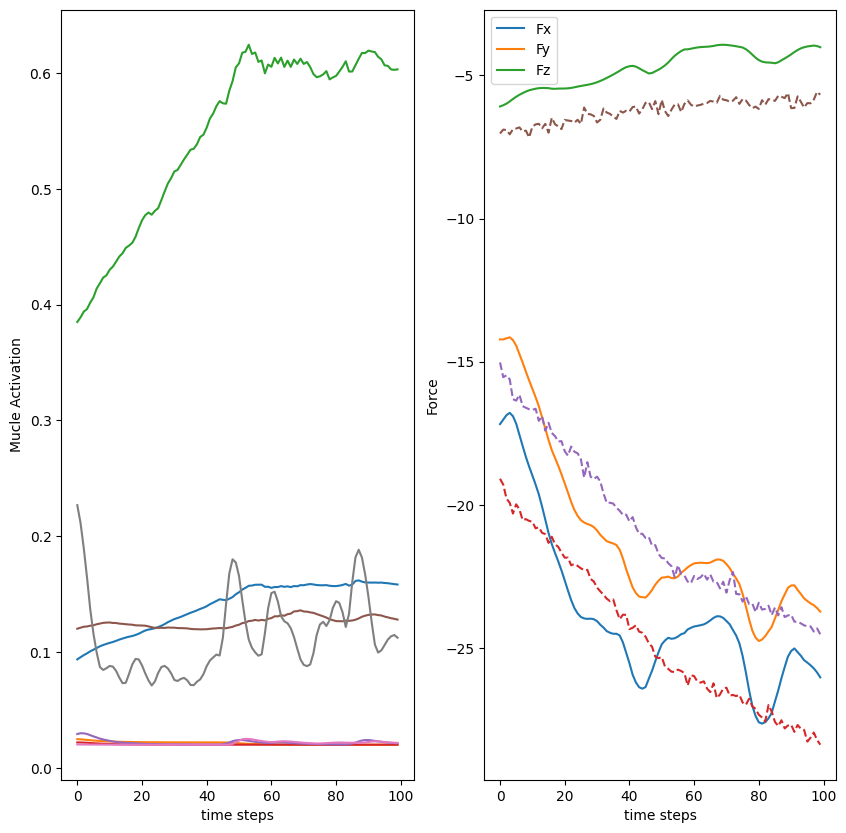

In [23]:
# plot a sample of the data
n = np.random.randint(0, len(test_data.X))
x_plot = torch.from_numpy(test_data.X[n].cpu().numpy()).float().detach().cpu().numpy()
y_plot = test_data.Y[n].float().detach().cpu().numpy().reshape(-1, 3)
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(x_plot)
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(y_plot)
    
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')
ax[1].legend(y_labels)
#plot the prediction of this sample
pred = model(test_data.X[n].float().to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
ax[1].plot(pred, '--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

In [24]:
# save the model state dict to the model folder
import os
# import the datetime properly
from datetime import datetime
def save_model(model, name):
    # check if models folder exists
    if not os.path.exists('models'):
        os.mkdir('models')
    # check if the model already exists and add a number to the end
    if os.path.exists('models/' + name + '.pt'):
        i = 0
        while os.path.exists('models/' + name + str(i) + '.pt'):
            i += 1
        torch.save(model.state_dict(), 'models/' + name + str(i) + '.pt')
    torch.save(model.state_dict(), 'models/' + name + '.pt')
# save the model include the todays date
save_model(model, 'lstm_3layer_30nodes_200epochs_' + str(datetime.now().date()))

In [85]:
# lets turn all this into a function

def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = stride)
    
    # scale all the x values
    window_Xs = [i[xcols].to_numpy() for i in window_dfs]
    print(window_Xs[0].shape)
    # get the prediciton for each window
    preds = [model(torch.from_numpy(x).float().to('cuda')).detach().cpu().numpy() for x in window_Xs]
    # add the prediciton to the dataframe
    for i, temp in enumerate(window_dfs):
        temp[ycols[0]+'_pred'] = preds[i][:,0]
        temp[ycols[1]+'_pred'] = preds[i][:,1]
        temp[ycols[2]+'_pred'] = preds[i][:,2]
    # average all time points
    group_df = pd.concat([i for i in window_dfs]).groupby(['Time']).mean()
    # make time a column and remove the index
    group_df['Time'] = group_df.index
    group_df = group_df.reset_index(drop=True)
    return group_df

def plot_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    group_df = get_event_prediction(event_df, model, window_size = window_size, stride=stride, xcols = xcols, ycols = ycols, device=device)
    # plot the data
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].plot(group_df[xcols])
    ax[0].set_xlabel('time steps')
    ax[0].set_ylabel('Mucle Activation')
    ax[1].plot(group_df[ycols])
    ax[1].set_xlabel('time steps')
    ax[1].set_ylabel('Force')
    ax[1].legend(ycols)
    #plot the prediction of this sample
    for i in ycols:
        ax[1].plot(group_df[i+'_pred'], '--')
    return group_df, 

41
52
(204, 8)


C:\Users\efons\AppData\Local\Temp\ipykernel_26848\3280007611.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df = pd.concat([i for i in window_dfs]).groupby(['Time']).mean()


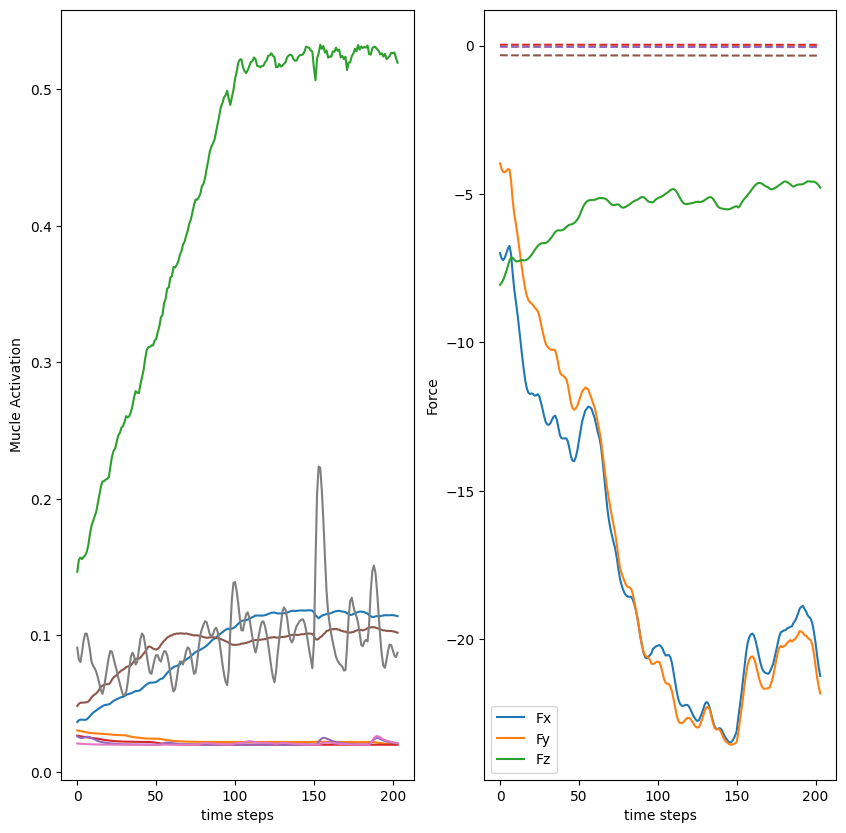

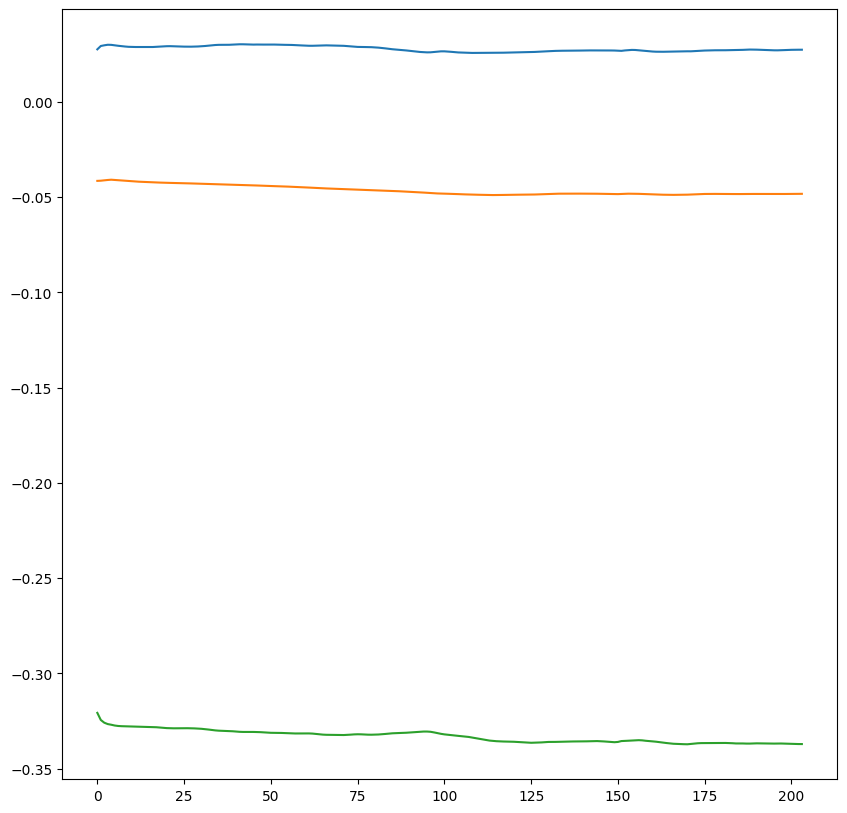

In [86]:
n = np.random.randint(0, len(test_data.subject_events))
print(n)
print(len(test_data.subject_events))
subject_events = test_data.subject_events[n]
j = np.random.randint(0, len(subject_events))
group_df = plot_event_prediction(test_data.subject_events[n][j], model, window_size = 100, stride = 50, xcols=test_data.xcols, ycols=test_data.ycols, device='cuda')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(group_df[0]['Fx_pred'])
ax.plot(group_df[0]['Fy_pred'])
ax.plot(group_df[0]['Fz_pred'])

In [83]:
model(test_data.subject_event_windows[0][])

AttributeError: 'DataFrame' object has no attribute 'dim'

Object `y.unsqueeze` not found.


In [28]:
group_df

,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject,Fx_pred,Fy_pred,Fz_pred,Time
0,0.02,0.329492,0.331428,0.020453,0.02,0.020000,0.119310,-11.131973,0.638932,10.907508,0.02,4.54_0.95_1.02,0.012978,-0.038815,-0.327536,0.000000
1,0.02,0.337095,0.337297,0.020400,0.02,0.020000,0.122460,-11.368239,0.587373,11.061823,0.02,4.54_0.95_1.02,0.007996,-0.037508,-0.323395,0.009799
2,0.02,0.340715,0.341795,0.020358,0.02,0.020113,0.123188,-11.568795,0.530623,11.195306,0.02,4.54_0.95_1.02,0.003625,-0.036570,-0.319185,0.019599
3,0.02,0.346106,0.347565,0.020315,0.02,0.020703,0.123150,-12.329645,0.242364,11.451779,0.02,4.54_0.95_1.02,0.001341,-0.036510,-0.318095,0.029398
4,0.02,0.349165,0.352451,0.020278,0.02,0.021790,0.122987,-12.409715,0.212035,11.443774,0.02,4.54_0.95_1.02,-0.000098,-0.036696,-0.317507,0.039197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.02,0.641878,0.780307,0.245638,0.02,0.020876,0.239333,-49.674675,-11.795664,27.967259,0.02,4.54_0.95_1.02,-0.054004,-0.050379,-0.311489,1.950067
200,0.02,0.642500,0.780480,0.244316,0.02,0.020761,0.239458,-49.573904,-11.728156,27.940522,0.02,4.54_0.95_1.02,-0.054044,-0.050399,-0.311374,1.959866
201,0.02,0.643054,0.780150,0.242641,0.02,0.020658,0.239575,-49.432558,-11.643054,27.898285,0.02,4.54_0.95_1.02,-0.054089,-0.050420,-0.311236,1.969666
202,0.02,0.643895,0.780389,0.241556,0.02,0.020795,0.239705,-49.299704,-11.561206,27.860610,0.02,4.54_0.95_1.02,-0.054139,-0.050442,-0.311079,1.979465


In [29]:
test_data.subject_events[0]

[           Time       FCU       EPL       EPB       FPL       APL       FPB  \
 47940  0.000000  0.039495  0.043344  0.021539  0.048525  0.023688  0.022651   
 47941  0.009799  0.040474  0.043066  0.022578  0.054433  0.023881  0.022564   
 47942  0.019599  0.040567  0.043037  0.023400  0.057617  0.024247  0.022495   
 47943  0.029398  0.040286  0.043283  0.024580  0.060438  0.024770  0.022435   
 47944  0.039197  0.040714  0.043538  0.026125  0.064465  0.025138  0.022390   
 ...         ...       ...       ...       ...       ...       ...       ...   
 48139  1.950067  0.169536  0.046810  0.221184  0.530449  0.057860  0.020750   
 48140  1.959866  0.169754  0.046763  0.221261  0.531151  0.057975  0.020664   
 48141  1.969666  0.169525  0.046703  0.220961  0.528976  0.058040  0.020576   
 48142  1.979465  0.169287  0.047131  0.220160  0.525838  0.058209  0.020507   
 48143  1.989264  0.168236  0.048316  0.218518  0.520139  0.058537  0.020549   
 
             OPP         Fx         Fy

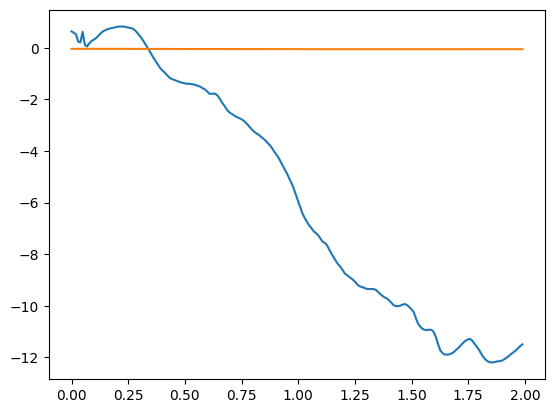

In [30]:
plt.plot(group_df['Time'], group_df['Fy'])
plt.plot(group_df['Time'], group_df['Fy_pred'])

In [31]:
preds[0].shape

(100, 300)

<AxesSubplot: xlabel='Time'>

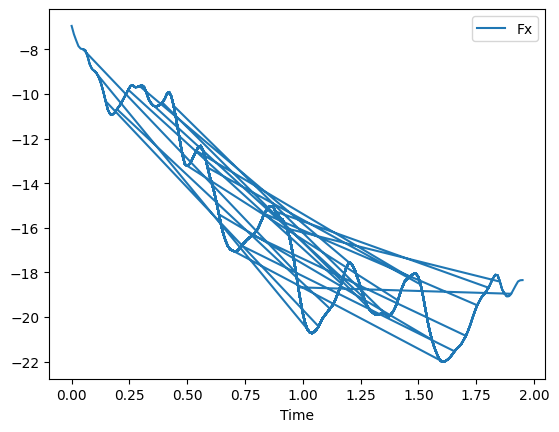

In [32]:
plot_df.plot(x='Time', y='Fx')

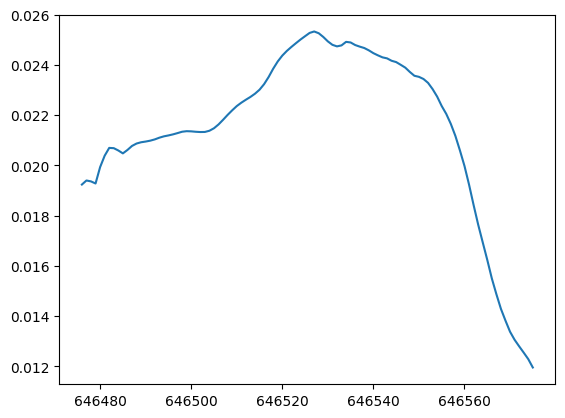

In [33]:
plt.plot(pred_plot[0]['Fx_pred'])

In [34]:
torch.__version__

'1.13.0+cu117'